In [17]:
import os
import sys
import json
import pathlib 
cwd = pathlib.Path.cwd()
sys.path.insert(0, str(cwd.parent.joinpath("turk", "analysis")))
from analysis import parse_csv
from collections import defaultdict, OrderedDict 
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt
np.random.seed(12)

def group_by(res_lines, variable_name):
    to_ret = defaultdict(list)
    for line in res_lines:
        interest_key = line[variable_name]
        to_ret[interest_key].append(line)
        
    return to_ret

def sort_by_fxn(res_dict, fxn):
    new_dict = OrderedDict()
#     average = lambda x: sum(x)/len(x)
    to_sort = []
    for key, values in res_dict.items():
        ps = [line['p_true'] for line in values]
        score = fxn(ps)
        to_sort.append((score, key, values))
    to_sort = sorted(to_sort, key = lambda x: x[0])
    
    for __, key, values in to_sort:
        new_dict[key] = values
    return new_dict

def add_model_data(path, data):
    with open(path) as f1:
        model_data = json.load(f1)
    
    model_data_dict = {data["questionId"]: data for data in model_data}
    
    for i, item in enumerate(data):
        qid = item["question_id"]
        model_pred = model_data_dict[qid]['prediction']

        model_p_yes = model_pred["yes"]
        model_p_no = model_pred["no"]
        assert(model_p_yes + model_p_no > 0.98)
        model_p_yes *= 100
        data[i]["model_p_true"] = model_p_yes
        
    return data


In [18]:

results_path = cwd.parent.parent.joinpath("results")
lxmert_path = results_path.joinpath("lxmert", "gqa")
turk_path = results_path.joinpath("turk", "gqa")

# all_data_paths 
all_data = {}
for csv in lxmert_path.glob("*.json"):
    filename = csv.stem
    unit = filename.split("_")[1]
    turk_name = f"clean_and_norm_{unit}.csv"
    try:
        res_lines = parse_csv(turk_path.joinpath(turk_name))
        res_lines = add_model_data(csv, res_lines)
    except FileNotFoundError:
        print(f"error with {filename}")
        continue
        
    by_sent = group_by(res_lines, "question_id")

    by_sent_sorted_avg = sort_by_fxn(by_sent, lambda x: np.mean(x))
    all_data[filename] = by_sent_sorted_avg

figure_path = "/Users/Elias//vagueness-2020/figures/"


error with output_tiny


In [19]:
import os
from analysis import parse_csv
from collections import defaultdict, OrderedDict 
import seaborn as sns
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt 

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
np.random.seed(12)

def plot_data(data, title_text, sigmoid_params = None, of_interest = None, do_save = False):
    xs = np.arange(len(data.keys()))
    human_ys = [np.mean([line['p_true']  for line in data[key] ] ) for key in data.keys() ]
    human_std_dev = np.array([np.std([line['p_true']  for line in data[key] ] ) for key in data.keys() ])
    human_std_err = human_std_dev / np.sqrt(10) # np.sqrt(len(human_ys)) 
    # all the same value so mean = any of them 
    model_ys = [np.mean([line['model_p_true'] for line in data[key]] ) for key in data.keys()]
    sents = [line[0]['sent'] for line in data.values()]
    qids = [line[0]['question_id'] for line in data.values()]
    all_lines = [lines[0] for lines in data.values() ]
    true_colors = ["True" if np.mean([line['p_true']  for line in data[key] ]) > 50 else "False" for key in data.keys() ]

    palette = {"True": '#4575b4' ,
               "False": '#e34a33'}
    markers = {"True": "." ,
               "False": "."}

    plt.figure()

    fig, axs = plt.subplots(2, 1, sharex='col', sharey=True, figsize=(6,6))
    axs[0].set_title(title_text)
    axs[0].fill_between(xs, human_ys - human_std_err, human_ys + human_std_err, color=(0,0,0,0.15))

    for x, human_y, model_y, c, s, qid in zip(xs, human_ys, model_ys, true_colors, sents, qids):
        color = c  
        axs[0].scatter([x], [human_y], s = 150, marker = markers[c], color = palette[color])
        axs[1].scatter([x], [model_y], s = 150, marker = markers[c], color = palette[color])

    # iterate again so rings are on top 
    for x, human_y, model_y, c, s, qid in zip(xs, human_ys, model_ys, true_colors, sents, qids):
        if of_interest is not None and qid in of_interest:
            axs[0].scatter([x], [human_y], s = 400, marker = ".", color = (0,0,0))
            axs[0].scatter([x], [human_y], s = 100, marker = ".", color = palette[c])
            axs[1].scatter([x], [model_y], s = 400, marker = ".", color = (0,0,0))
            axs[1].scatter([x], [model_y], s = 100, marker = ".", color = palette[c])

    
    if sigmoid_params is not None:
        sigmoid_xs = xs 
        sigmoid_ys = np.array([sigmoid(x, *sigmoid_params) for x in sigmoid_xs]) * 100
        axs[0].plot(sigmoid_xs, sigmoid_ys, "-", color = (0,0,0), linewidth=2)
        axs[1].plot(sigmoid_xs, sigmoid_ys, "-", color = (0,0,0), linewidth=2)

    for i in range(2):
        axs[i].set_yticks([0.0, 100])
        axs[i].set_yticklabels([0.0, 100])
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
    #     axs.spines['left'].set_visible(False)
        axs[i].spines['bottom'].set_visible(True)
    axs[0].set_ylabel("Human", rotation = 90, labelpad = -10)
    axs[1].set_ylabel("LXMERT", rotation = 90, labelpad = -10)
    
    plt.tight_layout()
    if do_save:
        plt.savefig(os.path.join(figure_path, f"{title_text}_gqa.pdf")) 
    return plt

In [20]:
from scipy.optimize import curve_fit
np.random.seed(12)
def sigmoid(x, x0, k):
    return 1.0 / (1.0 + np.exp(-k * (x-x0)))

def get_rmse(pred_ys, true_ys):
    return np.sqrt(np.sum((pred_ys - true_ys)**2) / len(pred_ys))

def fit_sigmoid(data, folds = 10):
    xs = np.arange(len(data.keys()))
    all_human_ys = [np.mean([line['p_true']  for line in data[key] ] ) for key in data.keys() ]
    all_human_ys = np.array(all_human_ys)/100
    all_model_ys = [np.mean([line['model_p_true']  for line in data[key] ] ) for key in data.keys()]
    all_model_ys = np.array(all_model_ys)/100
    bounds=([0,len(xs)+2], [0.01, 2])
    
    all_human_rmse, all_model_rmse, all_random_rmse = [], [], []
    all_popts = []
    
    # shuffle data
    zipped = list(zip(xs, all_human_ys, all_model_ys))
    np.random.seed(12)
    np.random.shuffle(zipped)
    xs, all_human_ys, all_model_ys = zip(*zipped)

    idxs = [i for i in range(len(xs))]
    for fold in range(folds):
        train_xs, train_human_ys, dev_human_ys, train_model_ys, dev_model_ys = None, None, None, None, None
        start = int(fold/folds * len(xs))
        end = int((fold+1)/folds * len(xs))
        
        dev_idxs = idxs[start:end]
        train_idxs = [idx for idx in idxs if idx not in dev_idxs]
        
        dev_xs = np.array([xs[idx] for idx in dev_idxs])
        train_xs = np.array([xs[idx] for idx in train_idxs])
    
        train_human_ys = np.array([all_human_ys[idx] for idx in train_idxs])
        dev_human_ys = np.array([all_human_ys[idx] for idx in dev_idxs])
        train_model_ys = np.array([all_model_ys[idx] for idx in train_idxs])
        dev_model_ys = np.array([all_model_ys[idx] for idx in dev_idxs])

        midpoint = len(xs)/2
        
        popt_human, pcov_human = curve_fit(sigmoid, 
                                           train_xs, 
                                           train_human_ys,
                                           p0 = [midpoint, 0.1], 
                                           method='dogbox')
        pred_ys_human = np.array([sigmoid(x, popt_human[0], popt_human[1]) for x in dev_xs])
        rmse_pred_to_human = get_rmse(pred_ys_human, dev_human_ys) 
        all_human_rmse.append(rmse_pred_to_human)
        all_popts.append(popt_human)
        
        
        for param in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
            try:
                popt_model, pcov_model = curve_fit(sigmoid, 
                                           train_xs, 
                                           train_model_ys,
                                           p0 = [midpoint, param], 
                                           method='dogbox')
                pred_ys_model = np.array([sigmoid(x, popt_model[0], popt_model[1]) for x in dev_xs])
                rmse_pred_to_model = get_rmse(pred_ys_model, dev_model_ys)
                all_model_rmse.append(rmse_pred_to_model)
                break
            except RuntimeError:
                continue
                
        train_random_ys = np.random.uniform(size=len(train_human_ys))
        dev_random_ys = np.random.uniform(size=len(dev_human_ys))

        for param in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
            try:
                popt_random, pcov_random = curve_fit(sigmoid, 
                                           train_xs, 
                                           train_random_ys,
                                           p0 = [midpoint, 1], 
                                           method='dogbox')
                pred_ys_random = np.array([sigmoid(x, popt_random[0], popt_random[1]) for x in dev_xs])
                rmse_pred_to_random = get_rmse(pred_ys_random, dev_random_ys)
                all_random_rmse.append(rmse_pred_to_random)
                break
            except RuntimeError:
                continue

    return (np.mean(all_human_rmse), 
           np.mean(all_model_rmse),
           np.mean(all_random_rmse), 
           np.mean(np.array(all_popts)))

In [22]:

fits = {}
data_for_latex = {}
for name, data in all_data.items():
    human_rmse, model_rmse, random_rmse, popt = fit_sigmoid(data, folds = 10)
    fits[name] = (human_rmse, model_rmse, random_rmse, popt)
    human_rmse = np.format_float_positional(human_rmse, 3)
    model_rmse = np.format_float_positional(model_rmse, 3)
    random_rmse = np.format_float_positional(random_rmse, 3)
    data_for_latex[name] = [human_rmse, model_rmse,random_rmse]
#     print(f"{name} human rmse: {human_rmse}, model rmse: {model_rmse}, random rsme: {random_rmse}")

HEADER = """\\begin{tabular}{llll}
            \\hline
            Predicate & Human & Model & Random \\\\
            \\hline
            """
body = ""
for name in ["output_sunny_yesno_small", "output_cloudy_yesno_small", "output_new_yesno_small", "output_old_yesno_small", "output_young_yesno_small", "output_adult_yesno_small"]:
    row_data = data_for_latex[name]
    just_name = name.split("_")[1]
    row = " & ".join([just_name] + row_data) + "\\\\"
    row += "\n"
    body+=row

FOOTER = """\\end{tabular}"""

print(HEADER + body + FOOTER)


cwd = pathlib.Path.cwd()
data_path = cwd.parent.parent.joinpath("results","turk","gqa","for_latex.json")
with open(data_path,"w") as f1:
    json.dump(data_for_latex, f1)

/Users/Elias/miniconda3/envs/vagueness/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


\begin{tabular}{llll}
            \hline
            Predicate & Human & Model & Random \\
            \hline
            sunny & 0.026 & 0.325 & 0.272\\
cloudy & 0.029 & 0.284 & 0.268\\
new & 0.079 & 0.22 & 0.298\\
old & 0.027 & 0.302 & 0.308\\
young & 0.082 & 0.307 & 0.284\\
adult & 0.017 & 0.286 & 0.271\\
\end{tabular}


<Figure size 432x288 with 0 Axes>

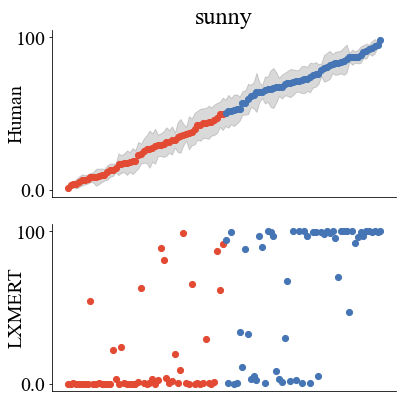

<Figure size 432x288 with 0 Axes>

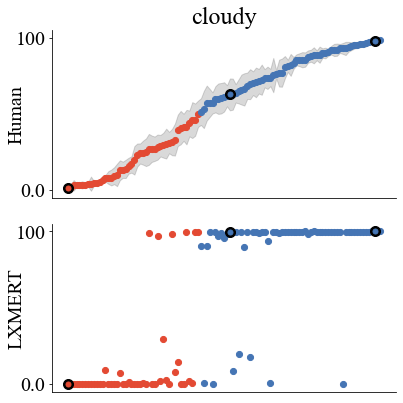

<Figure size 432x288 with 0 Axes>

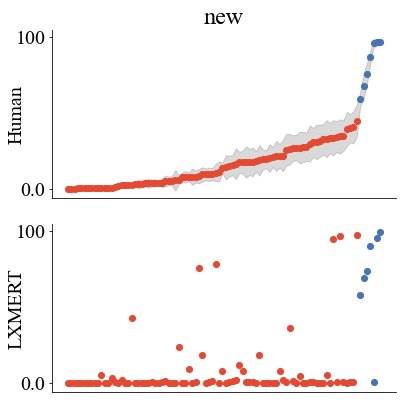

<Figure size 432x288 with 0 Axes>

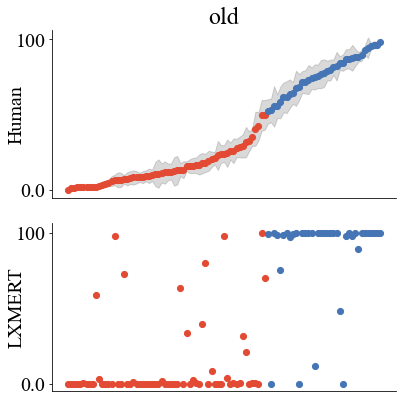

<Figure size 432x288 with 0 Axes>

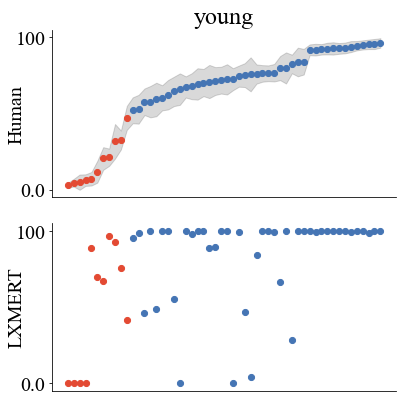

<Figure size 432x288 with 0 Axes>

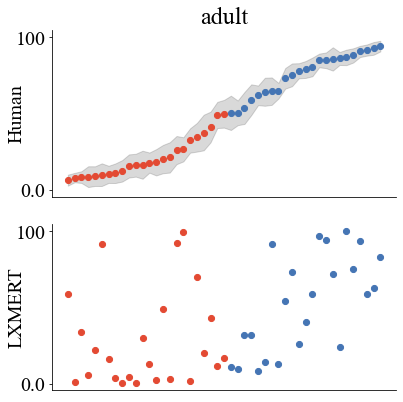

In [16]:

filenames = ["output_sunny_yesno_small", "output_cloudy_yesno_small",
              "output_new_yesno_small","output_old_yesno_small",
             "output_young_yesno_small", "output_adult_yesno_small"]
names = ["sunny","cloudy","new","old", "young","adult"]
# of_interest = ['03959852', '18812880', '18590951']
of_interest = ["01689349", "06991628", "02131675"]

for filename, name in zip(filenames,names):
#     plot_data(all_data[filename], name, sigmoid_params = fits[filename][-1], of_interest = of_interest)
    plot_data(all_data[filename], name, sigmoid_params = None, of_interest = of_interest, do_save = True)



In [13]:
# example search 
filenames = ["output_cloudy_yesno_small"] #, "output_cloudy_yesno_small"]
names = ["cloudy"] #,"cloudy"]
for filename, name in zip(filenames,names):
    data = all_data[filename]
    keys = list(data.keys())
#     print(filename, len(data))
    print("NOT VAGUE NO")
    for i in range(0, 3):
        print(data[keys[i]][0])
    print("==============================")
    
    print("VAGUE")
    midpoint = int(len(data)/2)
    for i in range(midpoint-5, midpoint+5):
        print(data[keys[i]][0])
    print("==============================")
    
    print("NOT VAGUE YES")

    for i in range(-3, -1):
        print(data[keys[i]][0])

    print("==============================")
    
    
    


NOT VAGUE NO
OrderedDict([('worker_id', 'A2NHFSO7GMM8QR'), ('assignment_id', '30BXRYBRP5266UW7NIMLX3U9RNFWHL'), ('question_id', '01689349'), ('p_true', 0.0), ('sent', 'Is the sky cloudy?-http://ugrad.cs.jhu.edu/~jgualla1/images/2384391.jpg'), ('start_time', 'Wed Sep 23 08:59:32 PDT 2020'), ('end_time', 'Wed Sep 23 09:12:08 PDT 2020'), ('p_true_norm', '0.0'), ('voted_decision', 'False'), ('num_na', '0'), ('model_p_true', 0.0005213423719396815)])
OrderedDict([('worker_id', 'AJ7JFYKBG85ZV'), ('assignment_id', '33CID57105YB1SD94JQHKYCJABUL3B'), ('question_id', '02996044'), ('p_true', 0.0), ('sent', 'Does the blue sky look cloudy?-http://ugrad.cs.jhu.edu/~jgualla1/images/2318396.jpg'), ('start_time', 'Wed Sep 23 09:01:41 PDT 2020'), ('end_time', 'Wed Sep 23 09:17:34 PDT 2020'), ('p_true_norm', '0.0'), ('voted_decision', 'False'), ('num_na', '0'), ('model_p_true', 0.00047483949856541585)])
OrderedDict([('worker_id', 'AJ7JFYKBG85ZV'), ('assignment_id', '33CID57105YB1SD94JQHKYCJABUL3B'), ('que

In [15]:
["01689349", "06991628", "02131675"]

['01689349', '06991628', '02131675']